In [1]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import math
import itertools
from random import choice

from datetime import datetime
from datetime import timedelta

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import pmdarima
from pmdarima.arima.utils import ndiffs

D:\Downloads\Anucleus\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Downloads\Anucleus\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Downloads\Anucleus\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


ModuleNotFoundError: No module named 'pmdarima'

In [2]:
df = pd.read_csv("2020Q1Q2Q3Q4-2021Q1.csv")

In [3]:
df.info

<bound method DataFrame.info of                 Date           Price                Open             High  \
0       Mar 31, 2021          291.02                 294           294.42   
1       Mar 30, 2021          293.25              294.86           295.72   
2       Mar 29, 2021           293.3              289.72           294.09   
3       Mar 26, 2021          291.22              288.63           292.75   
4       Mar 25, 2021          286.66               286.5           287.03   
..               ...             ...                 ...              ...   
307     Jan 09, 2020          257.99               259.4           261.76   
308     Jan 08, 2020          259.15              253.57           259.15   
309     Jan 06, 2020           253.9              254.75           254.84   
310     Jan 03, 2020             255              255.99           258.19   
311  Highest: 296.07  Lowest: 172.15  Difference: 123.92  Average: 234.52   

                 Low    Vol. Change %  
0  

In [4]:

df=pd.ExcelFile('trading_portfolio.xlsx')  
df.sheet_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

In [5]:
def read_clean_sheet (excel_file, sheet_name):
    """
    Input : Excel file in xlsx format
            sheet_name that is to be read into a dataframe
    Output : dataframe
    """
    df = pd.read_excel(excel_file, sheet_name = sheet_name)
    df = df.copy()
    df = df[:-1] #drop the last row
    df = df[df['Vol.']!='-'] # drop any rows where 'Vol' values are not specified (i.e. '-')
    df['Date'] = pd.to_datetime(df['Date'])#convert 'Date' column to datetime
    df = df.sort_values(['Date'], axis = 0, ascending=True, ignore_index =True) #arrange the data in ascending order
    df[['Price','Open', 'High', 'Low', 'Change %']] = df[['Price','Open', 'High', 'Low', 'Change %']].apply(pd.to_numeric)#convert
    #other columns to numeric values
    
    #drop the 'M' from 'Vol' column values indicating millions of shares
    # if the 'Vol' value is reported in thousands, i.e. 'K', then drop the 'K', convert the value to float and divide by 1000 to
    # to convert to millions, in line with other values in the 'Vol' column
    # the one line of code below accomplishes the 'Vol' value conversion
    df['Vol.'] = df['Vol.'].apply(lambda x: x[:-1] if 'M' in x else (float(x[:-1])/1000)).astype('float32')
    return df

In [6]:
excel_file = 'trading_portfolio.xlsx'

In [7]:
trading_portfolio = pd.ExcelFile(excel_file)
trading_portfolio

In [8]:
df = read_clean_sheet (excel_file, trading_portfolio.sheet_names[0])
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2020-01-03,255.00,255.99,258.19,253.70,35.849998,0.0010
1,2020-01-06,253.90,254.75,254.84,251.40,22.350000,-0.0043
2,2020-01-08,259.15,253.57,259.15,253.03,40.820000,0.0207
3,2020-01-09,257.99,259.40,261.76,257.01,38.330002,-0.0045
4,2020-01-10,258.19,257.86,259.25,256.88,18.850000,0.0008


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      311 non-null    datetime64[ns]
 1   Price     311 non-null    float64       
 2   Open      311 non-null    float64       
 3   High      311 non-null    float64       
 4   Low       311 non-null    float64       
 5   Vol.      311 non-null    float32       
 6   Change %  311 non-null    float64       
dtypes: datetime64[ns](1), float32(1), float64(5)
memory usage: 15.9 KB


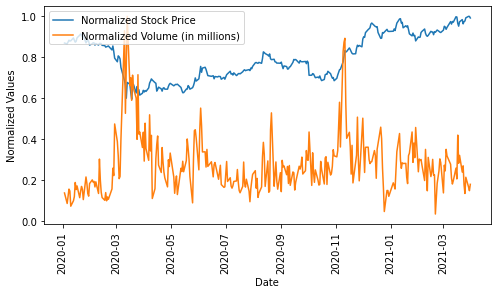

In [11]:
# plot the 'Price' and 'Vol.' columns, both normalized to their maximum values (so as to observe if there are trends between
# the stock price and the volume)
plt.figure(figsize = (8,4))
sns.lineplot(x = df['Date'], y = df['Price']/df['Price'].max())
sns.lineplot(x = df['Date'], y = df['Vol.']/df['Vol.'].max())
plt.xticks(rotation= 90)
plt.ylabel('Normalized Values')
plt.legend(loc = 'upper left', labels= ['Normalized Stock Price','Normalized Volume (in millions)'])
plt.show()
#there is no clear trend. Some increases in the price (between 2020-11 and 2021-01) is preceded by large transaction volumes
# while others (e.g. between 2020-4 and 2020-6) is not. 
# So transaction volumnes may not be a good indicator of a subsequent increase in stock prices

In [12]:
#define function to split data into training and testing sets
#also creates datasets for an exogenous variable (e.g. volume)
def train_test_sets (df, exog_var = 'Vol.'):
    """
    Input : dataframe, exogenous variable to be used in the ARIMAX model
    Output: X_train and X_test for the time series data that is to be predicted
            X_train_exog, X_test_exog for the exogenous variable
    """
    X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
    X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)
    X_train_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2020][exog_var].values)
    X_test_exog = list(df[pd.DatetimeIndex(df['Date']).year == 2021][exog_var].values)
    
    return X_train, X_test, X_train_exog, X_test_exog 

In [13]:
#split data in df to trainin and testing sets
X_train, X_test, X_train_exog, X_test_exog = train_test_sets (df, exog_var = 'Vol.')

In [14]:
X_train

[255.0,
 253.9,
 259.15,
 257.99,
 258.19,
 262.4,
 259.05,
 256.31,
 257.51,
 262.5,
 266.28,
 268.06,
 266.54,
 263.73,
 265.49,
 255.32,
 257.7,
 259.94,
 257.31,
 252.2,
 253.99,
 255.4,
 255.2,
 252.11,
 254.3,
 252.26,
 254.5,
 254.5,
 253.89,
 251.75,
 251.36,
 249.2,
 249.7,
 250.15,
 250.8,
 245.19,
 250.8,
 242.88,
 233.36,
 228.17,
 236.63,
 235.27,
 232.33,
 219.99,
 201.2,
 194.53,
 175.91,
 198.6,
 195.85,
 184.01,
 174.27,
 189.51,
 195.69,
 183.37,
 192.64,
 188.08,
 188.07,
 180.38,
 183.0,
 187.21,
 184.78,
 186.95,
 185.64,
 190.7,
 197.63,
 200.29,
 203.61,
 201.99,
 198.26,
 197.37,
 186.07,
 188.5,
 191.8,
 189.32,
 186.05,
 190.2,
 190.94,
 188.91,
 188.9,
 192.8,
 195.8,
 197.25,
 193.69,
 194.75,
 195.7,
 195.51,
 196.02,
 191.4,
 187.31,
 183.81,
 183.85,
 188.93,
 189.0,
 193.98,
 192.4,
 188.9,
 191.0,
 194.0,
 198.51,
 205.0,
 200.5,
 203.66,
 212.0,
 221.5,
 213.1,
 219.1,
 220.3,
 217.23,
 212.53,
 208.35,
 207.32,
 207.76,
 208.14,
 203.77,
 207.0,
 206.

In [15]:
len(X_train), len(X_test)

(250, 61)

In [16]:
def calc_errors (preds, truths):
    MAE = mean_absolute_error(preds, truths)
    MSE = mean_squared_error(preds, truths)
    MAPE = mean_absolute_percentage_error(preds, truths)
    return MAE, MSE, MAPE

In [17]:
# use the above identified p, d and q values (0,1,1) or (0,1,2) to train the ARIMA model

model_predictions = []
num_test_obser = len(X_test)

for i in range(num_test_obser):
    model = ARIMA(X_train, order = (0, 1, 2)) # where p = 0 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make them stationary
                                              # q = 0 which is the size of the moving average window
    model_fit =  model.fit()
    output = model_fit.forecast()
    
    model_predictions.append (output[0]) # append the predicted value to the model2_predictions list
    
    true_test_value = X_test[i] # the corresponding test value of the X_test list
    X_train.append(true_test_value)

In [18]:
model_predictions[:10] # compare predictions to actual share prices (next line of code)

[271.7579451815724,
 272.0132846456158,
 275.32757531359425,
 272.7034698348483,
 284.13236322670747,
 289.33596736348875,
 289.83340297584016,
 283.4722661807408,
 285.0862096518104,
 276.50158498808753]

In [19]:
X_test[:10]

[272.0, 275.2, 272.93, 283.64, 289.49, 289.99, 283.78, 284.79, 276.9, 279.79]

<AxesSubplot:xlabel='Date'>

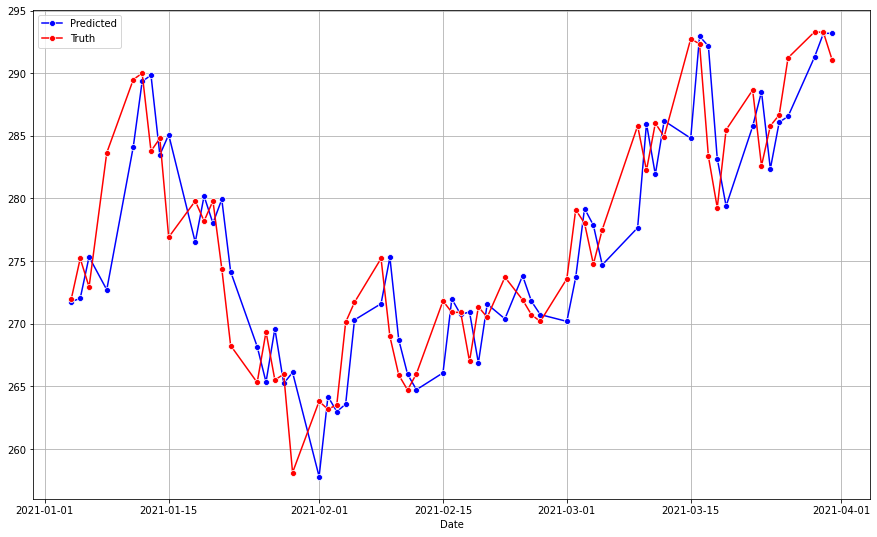

In [20]:
# plot the predicted and truth values for 2021

plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range, y=model_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')
#there is an offset of one day between Predicted and Truth values

In [6]:
#exploratory data analysis (specifically price line graph, make sure dates are proper. sometimes in jumbled order and not sequential.
#left to right, oldest to newest. 

#make sure dates start oldest at the top. newest at bottom.
#make sure dates column is in daytime format.

#choose which metric one wants for prediction. 
#open = soft market listing , hypothetical: on march xx, xxxx opening price and on march xx, xxxx closing price. Also,
#highest and lowest is top price for the day and lowest for the day. 

# pick one column for predictions, pick = price column *
#one would expect to project 10 days into the future ( more than 1 day).

#check pdq values and what they mean

#get rid of noise (usually aggregated on week, month)

#minimum points for arima is 52 or 53 (weekly level, sunday to saturday)

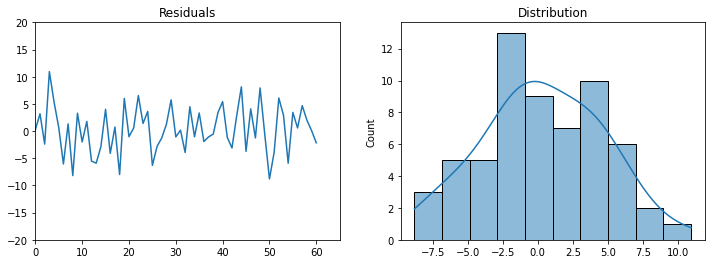

In [21]:
residuals = np.array(X_test) - np.array(model_predictions)
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.lineplot(x=range(len(residuals)), y = residuals, ax=axes[0])
axes[0].set_ylim([-20, 20])
axes[0].set_xlim([0, 65])
axes[0].set_title("Residuals")
sns.histplot(x=residuals, bins=10, kde=True, ax=axes[1])
axes[1].set_title("Distribution")
plt.show()
# the residual errors have a mean of 0 and variance that is normally distributed around mean of 0

In [22]:
#forecast the first 7 days of 2021

#first reset the training and testing data sets
X_train, X_test, X_train_exog, X_test_exog = train_test_sets (df, exog_var = 'Vol.')

model = ARIMA(X_train, order = (0, 1, 2))
model_fit =  model.fit()
output = model_fit.forecast(steps=7)

output

array([271.75794518, 271.76084741, 271.76084741, 271.76084741,
       271.76084741, 271.76084741, 271.76084741])

<AxesSubplot:xlabel='Date'>

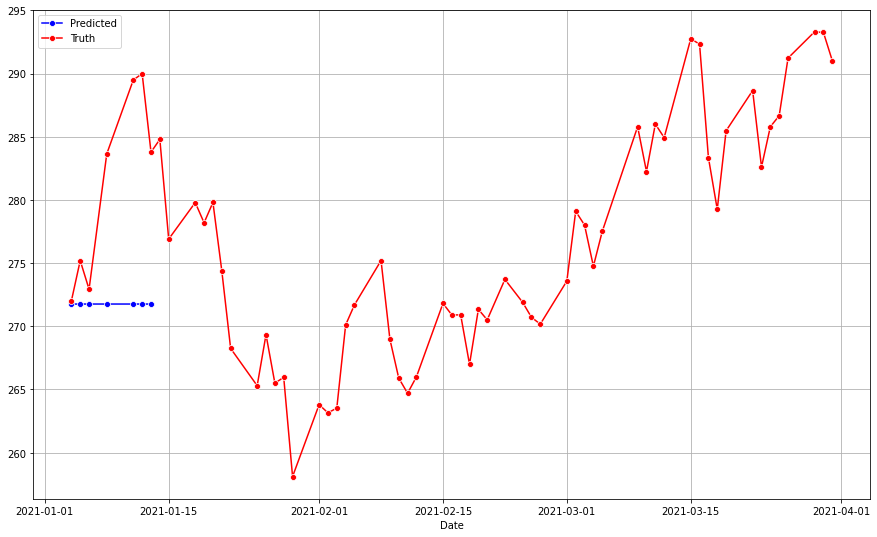

In [23]:
plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range[0:7], y=output, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')
#there is an offset of one day between Predicted and Truth values

In [ ]:
Forecasting past the first day is not accurate. Is this because the AR term of the ARIMA model is zero?

In [18]:
#autoregression
from statsmodels.tsa.ar_model import AutoReg
from random import random
# contrived dataset
data = ['Price']
# fit model
model = AutoReg(data, lags=1)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

ValueError: maxlag should be < nobs

In [8]:
#Moving average
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(0, 0, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)


[74.57867034]


In [9]:
#ARMA
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = [random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(2, 0, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[0.55123373]


In [6]:
#Arima
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data =  (need oldest to newest, input price*****)
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)

D:\Downloads\Anucleus\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Downloads\Anucleus\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Downloads\Anucleus\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[100.23854055]


In [11]:
#Sarima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[100.47347427]


D:\Downloads\Anucleus\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# SARIMAX example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
data1 = [x + random() for x in range(1, 100)]
data2 = [x + random() for x in range(101, 200)]
# fit model
model = SARIMAX(data1, exog=data2, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
exog2 = [200 + random()]
yhat = model_fit.predict(len(data1), len(data1), exog=[exog2])
print(yhat)

[100.7477554]


In [13]:
# Vector autoregression example
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = i + random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
# fit model
model = VAR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)


[[100.35821415 100.9187898 ]]


D:\Downloads\Anucleus\lib\site-packages\statsmodels\base\wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [14]:
# Vector autoregression moving average example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
# fit model
model = VARMAX(data, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.forecast()
print(yhat)

D:\Downloads\Anucleus\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


[[0.57093718 1.02898978]]


D:\Downloads\Anucleus\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
# Vector autoregression moving average with EXogenous regressors VARMAX example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
data_exog = [x + random() for x in range(100)]
# fit model
model = VARMAX(data, exog=data_exog, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
data_exog2 = [[100]]
yhat = model_fit.forecast(exog=data_exog2)
print(yhat)

D:\Downloads\Anucleus\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


[[0.41487061 1.03500114]]


D:\Downloads\Anucleus\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Downloads\Anucleus\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
D:\Downloads\Anucleus\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [16]:
# Simple exponential smoothing example
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = SimpleExpSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[99.26608477]


D:\Downloads\Anucleus\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [17]:
# Holt Winter's Exponential Smoothing example
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ExponentialSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)


[99.72963162]
